# Занятие 3. Эффект наложения спектров при дискретизации сигналов.

In [3]:
import scipy.integrate as integrate
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Задача 3.1. Эффект наложения при дискретизации прямоугольного импульса

In [4]:
def DTFT_abs3(xk, fs, M=2048):
    res=abs(np.fft.fftshift(np.fft.fft(xk, M)))
    return fs*np.arange(-1.5, 1.5, 1/M), np.hstack((res, res, res))
  
def integrate_function(t, func, f, tau, real_part=True):
    # Подынтегральное выражение для использованиия в функции integrate.quad
    # t - время
    # func - функция, задающая импульс
    # f - частота
    # tau - константа, используемая для задания длительности импульса
    if real_part:
        return func(t, tau)*np.cos(-2*np.pi*f*t)  # действительная часть интеграла
    else:
        return func(t, tau)*np.sin(-2*np.pi*f*t)  # мнимая часть интеграла

def fourier_transform(signal, f_band, tau, t1, t2, res_type='abs'):
    # вычисление преобразования Фурье для набора частот
    # signal - функция от t и tau, задающая сигнал во временной области 
    # f_band - набор частот, для которых вычисляется преобразование Фурье
    # tau - константа, используемая для задания длительности импульса
    # t1 момент начала сигнала
    # t2 момент завершения сигнала
    # тип возвращаемого значения:
    # res_type='abs' - |X(f)|
    # res_type='Re' - Re X(f)
    # res_type='Im' - Im X(f)
    if res_type=="abs":
        Re=np.array([integrate.quad(integrate_function, t1, t2, args=(signal, f, tau, True))[0] for f in f_band])
        Im=np.array([integrate.quad(integrate_function, t1, t2, args=(signal, f, tau, False))[0] for f in f_band])
        return abs(Re+1j*Im)
    elif res_type=="Re":
        Re=np.array([integrate.quad(integrate_function, t1, t2, args=(signal, f, tau, True))[0] for f in f_band])
        return Re
    elif res_type=="Im":
        Im=np.array([integrate.quad(integrate_function, t1, t2, args=(signal, f, tau, False))[0] for f in f_band])
        return Im

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


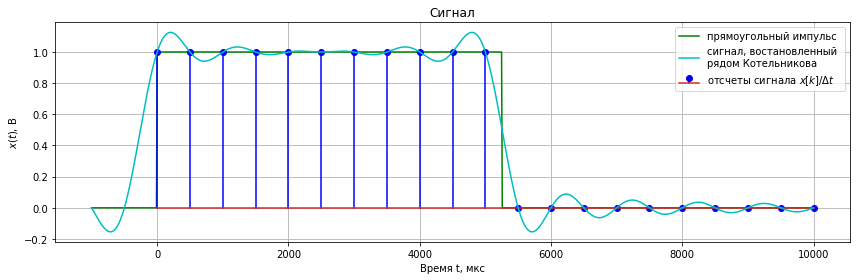

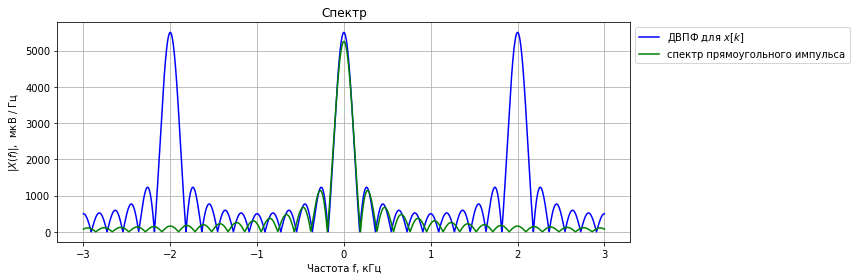

In [5]:
tau=5000*1e-6 #5000 мкс
fs=10/tau

f_band=np.linspace(-1.5*fs, 1.5*fs, 2000) # 2000 - число точек в диапазоне, в которых вычисляется X(f)

def boxcar(t, tau):
    if 0 <= t <= 1.05*tau:
        return 1.0 
    elif np.isclose(t, 1.05*tau, atol=1e-12) or np.isclose(t, 0, atol=1e-12):
        return 1.0 
    else:
        return 0.0 

def sinc_phi(t, k, fs):
    dt=1/fs
    if np.isclose(0, t-k*dt):
        return 1.0
    else:
        return np.sin(np.pi*fs*(t-k*dt))/(np.pi*fs*(t-k*dt))
    
def sinc_interp(t, xk):
    #print([xk*fs*sinc_phi(t, k, fs) for k in range(len(xk))])
    return sum([xk[k]*fs*sinc_phi(t, k, fs) for k in range(len(xk))])
    


tk = np.arange(0, 2*tau+1.0/fs, 1.0/fs, dtype=float)
xk = np.array([(1/fs)*boxcar(tk1, tau) for tk1 in tk])
    
t_band=np.linspace(-0.2*tau, 2*tau, 1024)
plt.figure(figsize=[12, 4])
plt.plot(t_band*1e6, [boxcar(t, tau) for t in t_band], 'g', label='прямоугольный импульс')
plt.stem(tk*1e6, xk*fs, 'b', 'bo', label='отсчеты сигнала $x[k]/{\\Delta t}$')



plt.plot(t_band*1e6, np.array([sinc_interp(t, xk) for t in t_band]), 'c', label='сигнал, востановленный \nрядом Котельникова')

plt.title("Сигнал")
plt.xlabel("Время t, мкс")
plt.ylabel("$x(t)$, В")
plt.grid()
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout() 

plt.figure(figsize=[12, 4])


DFTF_plot=DTFT_abs3(xk, fs)
plt.plot(DFTF_plot[0]/1e3, DFTF_plot[1]*1e6, 'b', label='ДВПФ для $x[k]$')

plt.plot(f_band/1e3, fourier_transform(signal=boxcar, f_band=f_band, tau=tau, t1=-2*tau, t2=2*tau, res_type="abs")*1e6, 
         'g', label='спектр прямоугольного импульса')

plt.title("Спектр")
plt.xlabel("Частота f, кГц")
plt.ylabel("$|X(f)|$,  мкВ / Гц")
plt.grid()
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout() 

In [6]:
fs

2000.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


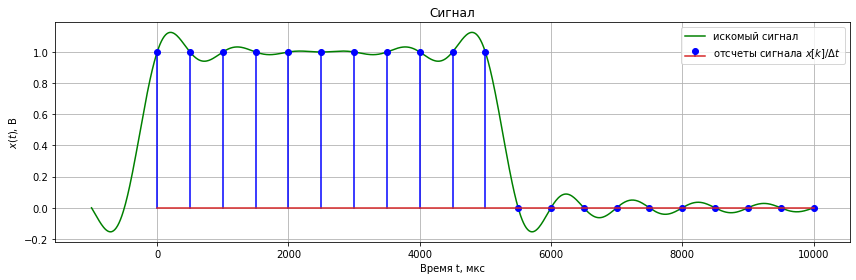

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


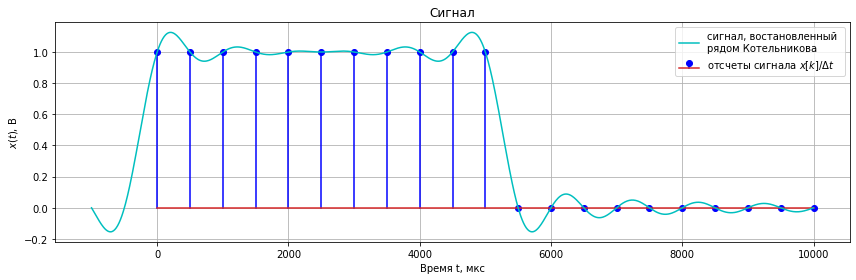

In [7]:
sig = np.array([sinc_interp(t, xk) for t in t_band])

t_band=np.linspace(-0.2*tau, 2*tau, 1024)
plt.figure(figsize=[12, 4])
plt.plot(t_band*1e6, sig, 'g', label='искомый сигнал')
plt.stem(tk*1e6, xk*fs, 'b', 'bo', label='отсчеты сигнала $x[k]/{\\Delta t}$')

plt.title("Сигнал")
plt.xlabel("Время t, мкс")
plt.ylabel("$x(t)$, В")
plt.grid()
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout() 
plt.show()

t_band=np.linspace(-0.2*tau, 2*tau, 1024)
plt.figure(figsize=[12, 4])
plt.stem(tk*1e6, xk*fs, 'b', 'bo', label='отсчеты сигнала $x[k]/{\\Delta t}$')
plt.plot(t_band*1e6, np.array([sinc_interp(t, xk) for t in t_band]), 'c', label='сигнал, востановленный \nрядом Котельникова')

plt.title("Сигнал")
plt.xlabel("Время t, мкс")
plt.ylabel("$x(t)$, В")
plt.grid()
plt.legend(loc='best', bbox_to_anchor=(1, 1))
plt.tight_layout() 
plt.show()

## Задача 3.2. Эффект наложения при прореживании сигнала

In [8]:
def DTFT_abs(xk, fs, M=2048):
    res=abs(np.fft.fftshift(np.fft.fft(xk, M)))
    return fs*np.arange(-0.5, 0.5, 1/M), np.hstack((res)) 

893 1154 2048
-2820.849609375 2799.31640625
2820.849609375
31.267175572519083


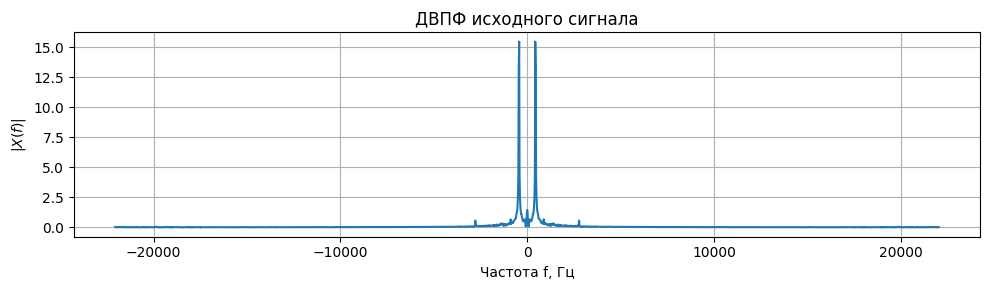

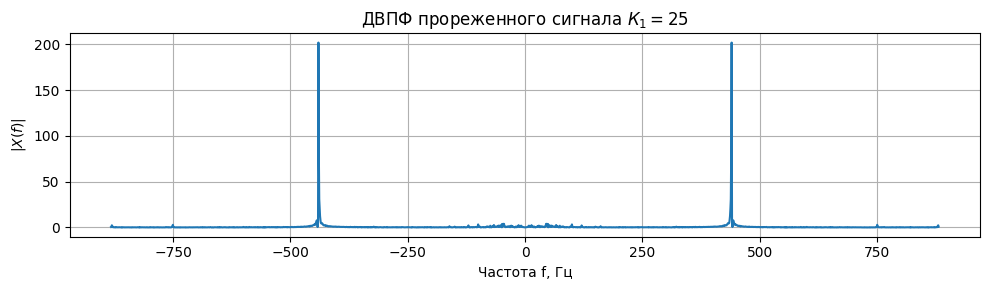

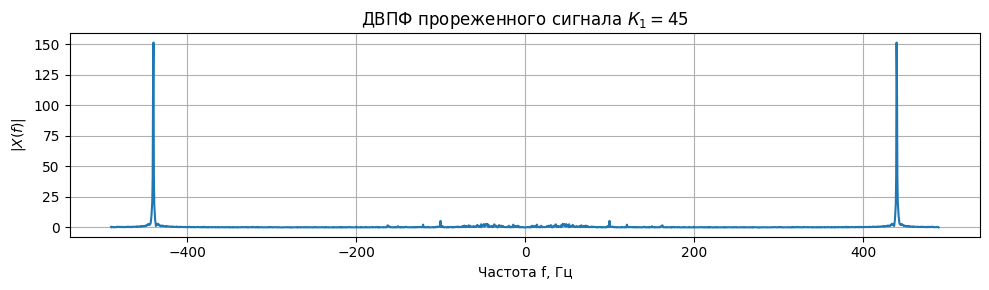

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io.wavfile
from scipy import signal

def find_fd(x):
  left = 0
  right = len(x) - 1
  while x[left] < 0.05:
    left += 1
  while x[right] < 0.05:
    right -= 1
  return left, right

fs, x=scipy.io.wavfile.read('/content/drive/MyDrive/Classroom/Лаборатория ИКТ (Б01-908, Б01-909)/Lab1/Sounds/tuning-fork.wav')
#for mono channel 
#x=x[:,1] 
left, right = find_fd(x)
print()


plt.figure(figsize=[10, 3], dpi=100)

DFTF_plot=DTFT_abs(x/fs, fs)
plt.plot(DFTF_plot[0], DFTF_plot[1])
plt.grid()
plt.title("ДВПФ исходного сигнала")
plt.xlabel("Частота f, Гц")
plt.ylabel("$|X(f)|$")
plt.tight_layout() 

# downsampling
plt.figure(figsize=[10, 3], dpi=100)
K=25
y=np.zeros(x.size//K+1)

u=0
for xk in np.arange(0, x.size, K):
    y[u]=x[xk]/K
    u=u+1
# end 
DFTF_plot=DTFT_abs(y/(fs/K), fs/K)
plt.plot(DFTF_plot[0], DFTF_plot[1])
plt.grid()
plt.title("ДВПФ прореженного сигнала $К_1=$%i" %K)
plt.xlabel("Частота f, Гц")
plt.ylabel("$|X(f)|$")
plt.tight_layout() 

# downsampling
plt.figure(figsize=[10, 3], dpi=100)
K=1
y=np.zeros(x.size//K+1)

u=0
for xk in np.arange(0, x.size, K):
    y[u]=x[xk]/K
    u=u+1
# end
    
DFTF_plot=DTFT_abs(y/(fs/K), fs/K)
plt.plot(DFTF_plot[0], DFTF_plot[1])
plt.grid()
plt.title("ДВПФ прореженного сигнала $К_1=$%i" %K)
plt.xlabel("Частота f, Гц")
plt.ylabel("$|X(f)|$")
plt.tight_layout() 